# Set up Google Colab

This means mounting drive and importing

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = 'Lab/Grain-U-Net'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/MyDrive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.

# %cd drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
# !bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME
#!pip install
#4/1AY0e-g5h4eZedG3k6mfdIj0OYbR717PFyEhKuxK5PidsrBbPRxi8fge6E3c

Mounted at /content/drive
/content/drive/My Drive/Lab/Grain-U-Net


In [107]:
from Model import *
#import Model
import data
import keras

# Train your Unet with membrane data
membrane data is in folder membrane/, it is a binary classification task.

The input shape of image and mask are the same :(batch_size,rows,cols,channel = 1)

### Train with data generator

In [ ]:
data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.00,
                    height_shift_range=0.00,
                    shear_range=0.00,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')
save_to_dir = None #'data/train/aug'
myGene = data.trainGenerator(2,'data/train','image','label',data_gen_args, save_to_dir = save_to_dir)
model = unet()
model_checkpoint = keras.callbacks.ModelCheckpoint('unet_grain.hdf5', monitor='loss',verbose=1, save_best_only=True)
model.fit_generator(myGene, steps_per_epoch=3000, epochs=3, callbacks=[model_checkpoint])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Found 54 images belonging to 1 classes.
Found 54 images belonging to 1 classes.
Epoch 1/3
3000/3000 [==============================] - 598s 182ms/step - loss: 0.0701 - accuracy: 0.9834

Epoch 00001: loss improved from inf to 0.05991, saving model to unet_grain.hdf5
Epoch 2/3
1536/3000 [==============>...............] - ETA: 4:08 - loss: 0.0469 - accuracy: 0.9836

### Train with npy file

In [ ]:
#imgs_train,imgs_mask_train = geneTrainNpy("data/membrane/train/aug/","data/membrane/train/aug/")
#model.fit(imgs_train, imgs_mask_train, batch_size=2, nb_epoch=10, verbose=1,validation_split=0.2, shuffle=True, callbacks=[model_checkpoint])

### test your model and save predicted results

1.0 0.004761904761904762


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


(29, 256, 256, 1) 255.0 111.71021


/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


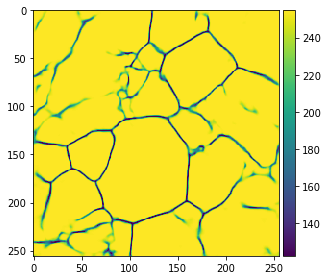

In [ ]:
from tensorflow.keras.preprocessing.image import load_img
def test_img(test_path,num_image = 30,target_size = (256, 256),flag_multi_class = False,as_gray = True,crop = None):
    img_stack = np.zeros((num_image,) + target_size)
    for i in range(num_image):
        img = load_img(os.path.join(test_path,"%d.png"%i), target_size=target_size, color_mode='grayscale')
        if crop:
            print('Cropping...')
            target_size_crop = 2 * [0]
            target_size_crop[0] = int(crop[0]/crop[2] * target_size[0])
            target_size_crop[1] = int(crop[1]/crop[3] * target_size[1])
            target_size_crop = tuple(target_size_crop)
            img = load_img(os.path.join(test_path,"%d.png"%i), target_size=target_size, color_mode='grayscale')
            img_arr = keras.preprocessing.image.img_to_array(img)
            img_arr = img_arr[:target_size[0], :target_size[1]]
            img = keras.preprocessing.image.array_to_img(img_arr)
        else:
            img = load_img(os.path.join(test_path,"%d.png"%i), target_size=target_size, color_mode='grayscale')
        img_stack[i] = img / (np.max(img))
    print(np.max(img_stack), np.min(img_stack))
    return img_stack

from skimage import io
import numpy as np
#testGene = data.testGenerator("data/test", target_size=(256,256))
test_set = test_img("data/test", num_image = 29)
model = unet()
model.load_weights("unet_grain.hdf5")
#results = 255 * model.predict_generator(testGene, 23, verbose=1)
# results = 255 * model.predict(testGene, 23)
results = 255 * model.predict(test_set, 29)
data.saveResult("data/test", results.astype('uint8'))
print(results.shape, np.max(results), np.min(results))
io.imshow(results[27, :, :, 0])

# Small Post Processing Stage

This next thing is just to visualize what the processing is doing before applying it to all the images

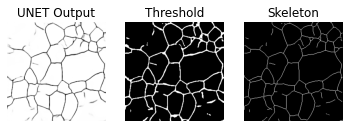

In [ ]:
from skimage import data, io, filters, morphology
import numpy as np
import matplotlib.pyplot as plt

def imsubplot(ax, im, cmap="gray", title=None):
    ax.imshow(im, cmap=cmap)
    ax.axis("off")
    if title:
        ax.set_title(title)

def post_process(path, thresh=255, verbose=False):
    image = io.imread(path)
    threshold = np.zeros(image.shape)
    threshold[image < thresh] = 1
    skeleton = morphology.skeletonize(threshold)
    
    if verbose:
        fig, (a, b, c) = plt.subplots(ncols=3)
        
        imsubplot(a, image, title='UNET Output')
        imsubplot(b, threshold, title='Threshold')
        imsubplot(c, skeleton, title='Skeleton')
        plt.show()
    else:
        return skeleton

post_process('data/test/0_predict.png', thresh=250, verbose=True)

#### This is to apply this processing to all the boundaries

In [ ]:
test_n = 29
test_dir = 'data/test/'

for i in range(test_n):
    im_path = f'{test_dir}{i}_predict.png'
    skel = 255 * post_process(im_path, thresh=250)
    io.imsave(f'{test_dir}{i}_processed.png', skel.astype('uint8')) 

# Overlay 

In [ ]:
from skimage import io, transform
import numpy as np
import os

test_n = 29
test_dir = 'data/test/'

for i in range(test_n):
    raw_img = io.imread(f'{test_dir}{i}.png')
    sk_img = io.imread(f'{test_dir}{i}_processed.png')
    sk_img = 255 * transform.resize(sk_img, raw_img.shape, anti_aliasing=False)
    fusion_img = np.zeros((raw_img.shape[0], raw_img.shape[1], 3), dtype=int)
    fusion_img[:, :, 0] = raw_img
    fusion_img[:, :, 1] = raw_img
    fusion_img[:, :, 2] = raw_img
    fusion_img[sk_img > 0, 0] = 255
    if os.path.isfile(f'{test_dir}key/{i}.png'):
        ht_img = io.imread(f'{test_dir}key/{i}.png')
        ht_img = 255 - (255 * transform.resize(ht_img, raw_img.shape, anti_aliasing=False))
        fusion_img[ht_img > 0, 1] = 255

    io.imsave(f'{test_dir}{i}_overlaid.png', fusion_img.astype('uint8')) 
#     io.imshow(fusion_img)
#     io.show()

# Chi2

In [ ]:
from chi2test import find_chi2
from skimage import io, transform
import os
import numpy as np
import time

test_dir = 'data/test/'
traced_dir = 'data/test/key/'
traced_names = np.sort(os.listdir(traced_dir))
traced = np.char.strip(traced_names, '.png')

chi2_dtype = [('img', (np.str_, 10)), ('chi2', np.float64), ('avg_chi2', np.float64)]
results = np.array([], dtype=chi2_dtype)

for key in traced:
    ml_img = io.imread(test_dir + key + '_processed.png')
    key_img = transform.resize(io.imread(traced_dir + key + '.png'), ml_img.shape)

    if np.min(key_img) != 0 or np.max(key_img) != 255:
        key_img -= np.min(key_img)
        key_img = np.round(key_img * (255 / np.max(key_img)))
    key_img = np.max(key_img) - key_img
    
    result = find_chi2(ml_img, key_img, out_dict=True)
    results = np.append(results, \
                np.array([(key, result["chi2"], result["avg_chi2"])], dtype=chi2_dtype))
    print(f'- img: {key} \t chi2: {result["chi2"]} \t avg_chi2: {result["avg_chi2"]} \t median_r2: {result["median_r2"]}')

print(f'\nAverage chi2: {np.mean(results["chi2"])}\nAverage avg_chi2: {np.mean(results["avg_chi2"])}\nMedian chi2: {np.median(results["chi2"])}')
print(f'Max chi2: {np.max(results["chi2"])}\nMin chi2: {np.min(results["chi2"])}')

- img: 0 	 chi2: 60429.0 	 avg_chi2: 23.449359720605354 	 median_r2: 0.0
- img: 1 	 chi2: 23919.0 	 avg_chi2: 7.671263630532392 	 median_r2: 0.0
- img: 10 	 chi2: 135697.0 	 avg_chi2: 40.53076463560335 	 median_r2: 0.0
- img: 11 	 chi2: 287719.0 	 avg_chi2: 107.67926646706587 	 median_r2: 0.0
- img: 12 	 chi2: 148700.0 	 avg_chi2: 61.24382207578254 	 median_r2: 0.0
- img: 13 	 chi2: 373096.0 	 avg_chi2: 236.4359949302915 	 median_r2: 0.0
- img: 14 	 chi2: 122802.0 	 avg_chi2: 70.29307384087006 	 median_r2: 0.0
- img: 15 	 chi2: 63593.0 	 avg_chi2: 27.553292894280762 	 median_r2: 0.0
- img: 16 	 chi2: 66228.0 	 avg_chi2: 44.034574468085104 	 median_r2: 0.0
- img: 17 	 chi2: 83670.0 	 avg_chi2: 38.31043956043956 	 median_r2: 0.0
- img: 18 	 chi2: 90169.0 	 avg_chi2: 36.38781275221953 	 median_r2: 0.0
- img: 19 	 chi2: 45505.0 	 avg_chi2: 30.934738273283482 	 median_r2: 0.0
- img: 2 	 chi2: 14571.0 	 avg_chi2: 5.494343891402715 	 median_r2: 0.0
- img: 20 	 chi2: 127584.0 	 avg_chi2: 49.83

**Here I'm indicating some of the hyper-parameters "E:[# Epochs] S:[Steps per epoch]"**
## Original Hyperparameters (Jul 9):
- img: 0 	 chi2: 33696 	 avg_chi2: 14.302207130730052
- img: 1 	 chi2: 17453 	 avg_chi2: 5.896283783783784
- img: 2 	 chi2: 2642 	 avg_chi2: 1.110550651534258
- img: 3 	 chi2: 36192 	 avg_chi2: 14.570048309178745
- img: 4 	 chi2: 166350 	 avg_chi2: 85.2202868852459
- img: 5 	 chi2: 55402 	 avg_chi2: 19.562853107344633
- img: 6 	 chi2: 32097 	 avg_chi2: 14.88038942976356
- img: 7 	 chi2: 108598 	 avg_chi2: 36.63900134952767
- img: 8 	 chi2: 38225 	 avg_chi2: 14.534220532319392
- img: 9 	 chi2: 45601 	 avg_chi2: 18.052652414885195
- img: 10 	 chi2: 65879 	 avg_chi2: 22.53043775649795
- img: 11 	 chi2: 205932 	 avg_chi2: 81.7514886859865
- img: 12 	 chi2: 36834 	 avg_chi2: 17.674664107485604

Average chi2: 64992.38461538462
Average avg_chi2: 26.671160318791017

Max chi2: 205932.0
Min chi2: 2642.0

## E:3 S:500 (Jul 12)
- img: 0 	 chi2: 104130 	 avg_chi2: 38.681277860326894
- img: 1 	 chi2: 34941 	 avg_chi2: 10.343694493783303
- img: 10 	 chi2: 170994 	 avg_chi2: 48.79965753424658
- img: 11 	 chi2: 392136 	 avg_chi2: 127.8565373328986
- img: 12 	 chi2: 267889 	 avg_chi2: 102.91548213599692
- img: 2 	 chi2: 13565 	 avg_chi2: 5.140204622963243
- img: 3 	 chi2: 53893 	 avg_chi2: 18.164138860802158
- img: 4 	 chi2: 291323 	 avg_chi2: 107.97739065974797
- img: 5 	 chi2: 206559 	 avg_chi2: 60.01133062173155
- img: 6 	 chi2: 117882 	 avg_chi2: 41.98076923076923
- img: 7 	 chi2: 277624 	 avg_chi2: 72.60041841004184
- img: 8 	 chi2: 85928 	 avg_chi2: 26.87769784172662
- img: 9 	 chi2: 213000 	 avg_chi2: 68.75403486120078

Average chi2: 171528.0
Average avg_chi2: 56.16174111278737

Max chi2: 392136.0
Min chi2: 13565.0

## E:5 S:2000 (Jul 12)
- img: 0 	 chi2: 5383 	 avg_chi2: 2.372410753635963
- img: 1 	 chi2: 9893 	 avg_chi2: 3.5106458481192333
- img: 10 	 chi2: 39345 	 avg_chi2: 15.21461716937355
- img: 11 	 chi2: 133482 	 avg_chi2: 60.2627539503386
- img: 12 	 chi2: 29105 	 avg_chi2: 14.895087001023542
- img: 2 	 chi2: 942 	 avg_chi2: 0.4124343257443082
- img: 3 	 chi2: 10375 	 avg_chi2: 4.631696428571429
- img: 4 	 chi2: 127879 	 avg_chi2: 74.34825581395349
- img: 5 	 chi2: 49989 	 avg_chi2: 20.3953488372093
- img: 6 	 chi2: 24439 	 avg_chi2: 11.979901960784314
- img: 7 	 chi2: 59255 	 avg_chi2: 23.825894652191394
- img: 8 	 chi2: 36177 	 avg_chi2: 15.264556962025317
- img: 9 	 chi2: 31360 	 avg_chi2: 13.652590335219852

Average chi2: 42894.153846153844
Average avg_chi2: 20.058938002937712

Max chi2: 133482.0
Min chi2: 942.0

## E:3 S:2000 (Jul 12)
- img: 0 	 chi2: 6038 	 avg_chi2: 2.624076488483268
- img: 1 	 chi2: 11210 	 avg_chi2: 3.9499647639182522
- img: 10 	 chi2: 40489 	 avg_chi2: 15.389205625237553
- img: 11 	 chi2: 184137 	 avg_chi2: 84.5829122645843
- img: 12 	 chi2: 46970 	 avg_chi2: 23.14933464760966
- img: 2 	 chi2: 551 	 avg_chi2: 0.23780750971083298
- img: 3 	 chi2: 13850 	 avg_chi2: 5.664621676891615
- img: 4 	 chi2: 141623 	 avg_chi2: 80.19422423556058
- img: 5 	 chi2: 39474 	 avg_chi2: 15.449706457925636
- img: 6 	 chi2: 23192 	 avg_chi2: 11.578632051922117
- img: 7 	 chi2: 81336 	 avg_chi2: 31.586796116504853
- img: 8 	 chi2: 29735 	 avg_chi2: 12.196472518457751
- img: 9 	 chi2: 32425 	 avg_chi2: 14.128540305010894

Average chi2: 50079.230769230766
Average avg_chi2: 23.13325343552441

Max chi2: 184137.0
Min chi2: 551.0

## E:1 S:2000 (Jul 12)
- img: 0 	 chi2: 27957 	 avg_chi2: 10.819272445820433
- img: 1 	 chi2: 26409 	 avg_chi2: 8.478009630818619
- img: 10 	 chi2: 128980 	 avg_chi2: 38.83769948810599
- img: 11 	 chi2: 287066 	 avg_chi2: 103.00179404377467
- img: 12 	 chi2: 70778 	 avg_chi2: 29.651445328864682
- img: 2 	 chi2: 10442 	 avg_chi2: 3.994644223412395
- img: 3 	 chi2: 31761 	 avg_chi2: 11.44953136265321
- img: 4 	 chi2: 221860 	 avg_chi2: 96.33521493703864
- img: 5 	 chi2: 87223 	 avg_chi2: 27.274233896185116
- img: 6 	 chi2: 79038 	 avg_chi2: 30.551990722844995
- img: 7 	 chi2: 184143 	 avg_chi2: 52.79329128440367
- img: 8 	 chi2: 68769 	 avg_chi2: 23.061368209255534
- img: 9 	 chi2: 85555 	 avg_chi2: 30.908598265895954

Average chi2: 100767.76923076923
Average avg_chi2: 35.93516106454415

Max chi2: 287066.0
Min chi2: 10442.0

## E:3 S:2000 (Jul 16)
- img: 0 	 chi2: 45684 	 avg_chi2: 18.9796427087661
- img: 1 	 chi2: 14301 	 avg_chi2: 4.786144578313253
- img: 10 	 chi2: 81017 	 avg_chi2: 27.764564770390677
- img: 11 	 chi2: 206634 	 avg_chi2: 78.50835866261399
- img: 12 	 chi2: 49130 	 avg_chi2: 22.26098776619846
- img: 2 	 chi2: 1233 	 avg_chi2: 0.5255754475703325
- img: 3 	 chi2: 9882 	 avg_chi2: 3.9214285714285713
- img: 4 	 chi2: 166070 	 avg_chi2: 82.33515121467526
- img: 5 	 chi2: 54112 	 avg_chi2: 19.188652482269504
- img: 6 	 chi2: 48879 	 avg_chi2: 21.86979865771812
- img: 7 	 chi2: 156015 	 avg_chi2: 50.75309043591412
- img: 8 	 chi2: 29388 	 avg_chi2: 10.973861090365945
- img: 9 	 chi2: 93680 	 avg_chi2: 36.16988416988417

Average chi2: 73540.38461538461
Average avg_chi2: 29.079780042777585

Max chi2: 206634.0
Min chi2: 1233.0

## E:3 S:2000 (Jul 16)
- img: 0 	 chi2: 45684.0 	 avg_chi2: 18.9796427087661 	 median_r2: 0.0
- img: 1 	 chi2: 14301.0 	 avg_chi2: 4.786144578313253 	 median_r2: 0.0
- img: 10 	 chi2: 81017.0 	 avg_chi2: 27.764564770390677 	 median_r2: 0.0
- img: 11 	 chi2: 206634.0 	 avg_chi2: 78.50835866261399 	 median_r2: 0.0
- img: 12 	 chi2: 49130.0 	 avg_chi2: 22.26098776619846 	 median_r2: 0.0
- img: 2 	 chi2: 1233.0 	 avg_chi2: 0.5255754475703325 	 median_r2: 0.0
- img: 3 	 chi2: 9882.0 	 avg_chi2: 3.9214285714285713 	 median_r2: 0.0
- img: 4 	 chi2: 166070.0 	 avg_chi2: 82.33515121467526 	 median_r2: 0.0
- img: 5 	 chi2: 54112.0 	 avg_chi2: 19.188652482269504 	 median_r2: 0.0
- img: 6 	 chi2: 48879.0 	 avg_chi2: 21.86979865771812 	 median_r2: 0.0
- img: 7 	 chi2: 156015.0 	 avg_chi2: 50.75309043591412 	 median_r2: 0.0
- img: 8 	 chi2: 29388.0 	 avg_chi2: 10.973861090365945 	 median_r2: 0.0
- img: 9 	 chi2: 93680.0 	 avg_chi2: 36.16988416988417 	 median_r2: 0.0

Average chi2: 73540.38461538461
Average avg_chi2: 29.079780042777585

Max chi2: 206634.0
Min chi2: 1233.0

## E:5 S:2000 Jul 18
- img: 0 	 chi2: 14852.0 	 avg_chi2: 6.657104437471985 	 median_r2: 0.0
- img: 1 	 chi2: 8988.0 	 avg_chi2: 3.262431941923775 	 median_r2: 0.0
- img: 10 	 chi2: 24693.0 	 avg_chi2: 10.195293146160198 	 median_r2: 0.0
- img: 11 	 chi2: 129829.0 	 avg_chi2: 62.68903911154032 	 median_r2: 0.0
- img: 12 	 chi2: 20062.0 	 avg_chi2: 10.757104557640751 	 median_r2: 0.0
- img: 2 	 chi2: 65.0 	 avg_chi2: 0.02918724741805119 	 median_r2: 0.0
- img: 3 	 chi2: 5085.0 	 avg_chi2: 2.320858055682337 	 median_r2: 0.0
- img: 4 	 chi2: 65290.0 	 avg_chi2: 41.322784810126585 	 median_r2: 0.0
- img: 5 	 chi2: 23800.0 	 avg_chi2: 10.175288584865328 	 median_r2: 0.0
- img: 6 	 chi2: 18989.0 	 avg_chi2: 9.983701366982125 	 median_r2: 0.0
- img: 7 	 chi2: 49975.0 	 avg_chi2: 22.181535730137593 	 median_r2: 0.0
- img: 8 	 chi2: 14375.0 	 avg_chi2: 6.525192918747163 	 median_r2: 0.0
- img: 9 	 chi2: 15279.0 	 avg_chi2: 7.123076923076923 	 median_r2: 0.0

Average chi2: 30098.615384615383
Average avg_chi2: 14.86327683321332
Median chi2: 18989.0

Max chi2: 129829.0
Min chi2: 65.0

## E:5 S:2000 Jul 19 (using the 1020x1020 images)
- img: 0 	 chi2: 16947.0 	 avg_chi2: 7.023207625362619 	 median_r2: 0.0
- img: 1 	 chi2: 14371.0 	 avg_chi2: 4.945285615966965 	 median_r2: 0.0
- img: 10 	 chi2: 79193.0 	 avg_chi2: 27.488024991322458 	 median_r2: 0.0
- img: 11 	 chi2: 261365.0 	 avg_chi2: 101.50097087378641 	 median_r2: 0.0
- img: 12 	 chi2: 65293.0 	 avg_chi2: 30.425442684063373 	 median_r2: 0.0
- img: 2 	 chi2: 7482.0 	 avg_chi2: 3.1201000834028356 	 median_r2: 0.0
- img: 3 	 chi2: 24632.0 	 avg_chi2: 9.333838575217886 	 median_r2: 0.0
- img: 4 	 chi2: 131380.0 	 avg_chi2: 68.14315352697095 	 median_r2: 0.0
- img: 5 	 chi2: 41536.0 	 avg_chi2: 15.69172648281073 	 median_r2: 0.0
- img: 6 	 chi2: 47220.0 	 avg_chi2: 20.3184165232358 	 median_r2: 0.0
- img: 7 	 chi2: 121347.0 	 avg_chi2: 41.330722070844686 	 median_r2: 0.0
- img: 8 	 chi2: 50557.0 	 avg_chi2: 19.36307927996936 	 median_r2: 0.0
- img: 9 	 chi2: 37577.0 	 avg_chi2: 15.5533940397351 	 median_r2: 0.0

Average chi2: 69146.15384615384
Average avg_chi2: 28.018258644053013
Median chi2: 47220.0

Max chi2: 261365.0
Min chi2: 7482.0

## E:3 S:1000 Jul  19 (1020x1020 images)
- img: 0 	 chi2: 32058.0 	 avg_chi2: 12.75178997613365 	 median_r2: 0.0
- img: 1 	 chi2: 23824.0 	 avg_chi2: 7.626120358514725 	 median_r2: 0.0
- img: 10 	 chi2: 113035.0 	 avg_chi2: 33.94444444444444 	 median_r2: 0.0
- img: 11 	 chi2: 400167.0 	 avg_chi2: 137.84602135721667 	 median_r2: 0.0
- img: 12 	 chi2: 100709.0 	 avg_chi2: 42.350294365012616 	 median_r2: 0.0
- img: 2 	 chi2: 12265.0 	 avg_chi2: 4.748354626403407 	 median_r2: 0.0
- img: 3 	 chi2: 55773.0 	 avg_chi2: 18.918928086838534 	 median_r2: 0.0
- img: 4 	 chi2: 197243.0 	 avg_chi2: 89.65590909090909 	 median_r2: 0.0
- img: 5 	 chi2: 55392.0 	 avg_chi2: 18.575452716297786 	 median_r2: 0.0
- img: 6 	 chi2: 66081.0 	 avg_chi2: 26.993872549019606 	 median_r2: 0.0
- img: 7 	 chi2: 217824.0 	 avg_chi2: 64.42590949423247 	 median_r2: 0.0
- img: 8 	 chi2: 68122.0 	 avg_chi2: 22.684648684648685 	 median_r2: 0.0
- img: 9 	 chi2: 84452.0 	 avg_chi2: 30.554269175108537 	 median_r2: 0.0

Average chi2: 109765.0
Average avg_chi2: 39.31353960959848
Median chi2: 68122.0

Max chi2: 400167.0
Min chi2: 12265.0

## E:3 S:4000 Jul 19 (1020x1020 imgs)
- img: 0 	 chi2: 60429.0 	 avg_chi2: 23.449359720605354 	 median_r2: 0.0
- img: 1 	 chi2: 23919.0 	 avg_chi2: 7.671263630532392 	 median_r2: 0.0
- img: 10 	 chi2: 135697.0 	 avg_chi2: 40.53076463560335 	 median_r2: 0.0
- img: 11 	 chi2: 287719.0 	 avg_chi2: 107.67926646706587 	 median_r2: 0.0
- img: 12 	 chi2: 148700.0 	 avg_chi2: 61.24382207578254 	 median_r2: 0.0
- img: 2 	 chi2: 14571.0 	 avg_chi2: 5.494343891402715 	 median_r2: 0.0
- img: 3 	 chi2: 38694.0 	 avg_chi2: 13.47753396029258 	 median_r2: 0.0
- img: 4 	 chi2: 234023.0 	 avg_chi2: 107.8944213923467 	 median_r2: 0.0
- img: 5 	 chi2: 101567.0 	 avg_chi2: 34.61724608043627 	 median_r2: 0.0
- img: 6 	 chi2: 89419.0 	 avg_chi2: 35.05252842022736 	 median_r2: 0.0
- img: 7 	 chi2: 197401.0 	 avg_chi2: 57.28409750435287 	 median_r2: 0.0
- img: 8 	 chi2: 57597.0 	 avg_chi2: 19.664390576988733 	 median_r2: 0.0
- img: 9 	 chi2: 77485.0 	 avg_chi2: 27.55512091038407 	 median_r2: 0.0

Average chi2: 112863.15384615384
Average avg_chi2: 41.662627635847755
Median chi2: 89419.0

Max chi2: 287719.0
Min chi2: 14571.0

## E:3 S:2000 Jul 19 (1020x1020)
- img: 0 	 chi2: 60429.0 	 avg_chi2: 23.449359720605354 	 median_r2: 0.0
- img: 1 	 chi2: 23919.0 	 avg_chi2: 7.671263630532392 	 median_r2: 0.0
- img: 2 	 chi2: 14571.0 	 avg_chi2: 5.494343891402715 	 median_r2: 0.0
- img: 3 	 chi2: 38694.0 	 avg_chi2: 13.47753396029258 	 median_r2: 0.0
- img: 4 	 chi2: 234023.0 	 avg_chi2: 107.8944213923467 	 median_r2: 0.0
- img: 5 	 chi2: 101567.0 	 avg_chi2: 34.61724608043627 	 median_r2: 0.0
- img: 6 	 chi2: 89419.0 	 avg_chi2: 35.05252842022736 	 median_r2: 0.0
- img: 7 	 chi2: 197401.0 	 avg_chi2: 57.28409750435287 	 median_r2: 0.0
- img: 8 	 chi2: 57597.0 	 avg_chi2: 19.664390576988733 	 median_r2: 0.0
- img: 9 	 chi2: 77485.0 	 avg_chi2: 27.55512091038407 	 median_r2: 0.0
- img: 10 	 chi2: 135697.0 	 avg_chi2: 40.53076463560335 	 median_r2: 0.0
- img: 11 	 chi2: 287719.0 	 avg_chi2: 107.67926646706587 	 median_r2: 0.0
- img: 12 	 chi2: 148700.0 	 avg_chi2: 61.24382207578254 	 median_r2: 0.0
- img: 13 	 chi2: 373096.0 	 avg_chi2: 236.4359949302915 	 median_r2: 0.0
- img: 14 	 chi2: 122802.0 	 avg_chi2: 70.29307384087006 	 median_r2: 0.0
- img: 15 	 chi2: 63593.0 	 avg_chi2: 27.553292894280762 	 median_r2: 0.0
- img: 16 	 chi2: 66228.0 	 avg_chi2: 44.034574468085104 	 median_r2: 0.0
- img: 17 	 chi2: 83670.0 	 avg_chi2: 38.31043956043956 	 median_r2: 0.0
- img: 18 	 chi2: 90169.0 	 avg_chi2: 36.38781275221953 	 median_r2: 0.0
- img: 19 	 chi2: 45505.0 	 avg_chi2: 30.934738273283482 	 median_r2: 0.0
- img: 20 	 chi2: 127584.0 	 avg_chi2: 49.8375 	 median_r2: 0.0
- img: 21 	 chi2: 356303.0 	 avg_chi2: 153.1168886978943 	 median_r2: 0.0
- img: 22 	 chi2: 39513.0 	 avg_chi2: 14.249188604399567 	 median_r2: 0.0
- img: 23 	 chi2: 148394.0 	 avg_chi2: 103.69951083158631 	 median_r2: 0.0
- img: 24 	 chi2: 243775.0 	 avg_chi2: 109.66036887089518 	 median_r2: 0.0
- img: 25 	 chi2: 152825.0 	 avg_chi2: 62.58190008190008 	 median_r2: 0.0
- img: 26 	 chi2: 170986.0 	 avg_chi2: 69.50650406504064 	 median_r2: 0.0
- img: 27 	 chi2: 982444.0 	 avg_chi2: 470.74460948730234 	 median_r2: 0.0
- img: 28 	 chi2: 145666.0 	 avg_chi2: 68.45206766917293 	 median_r2: 0.0

Average chi2: 161371.5172413793
Average avg_chi2: 73.35905601012698
Median chi2: 122802.0

Max chi2: 982444.0
Min chi2: 14571.0

## Chi2 Alignment

/home/jamie/.local/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


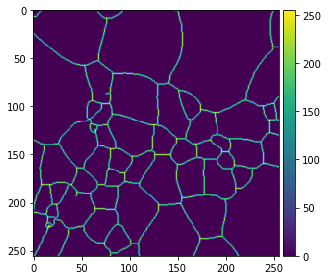

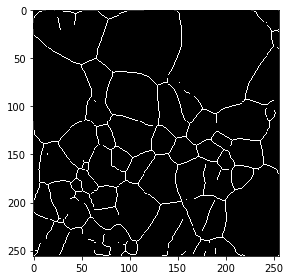

{'x': array([-1.]), 'y': array([1.]), 'chi2': 52921.0, 'avg_chi2': 26460.5}
55402
(260, 260, 3)
1 3 -3 -1
(260, 260, 3)
2 2 -2 -2


/home/jamie/.local/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


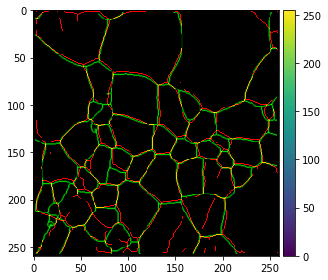

In [ ]:
from chi2test import *
from skimage import io, transform
import numpy as np

traced_n = 13
traced_dir = 'data/test/key/'

ml_img = io.imread('data/test/5_processed.png')
key_img = transform.resize(io.imread('data/test/key/5.png'), ml_img.shape)

if np.min(ml_img) != 0 or np.max(ml_img) != 255:
    ml_img -= np.min(ml_img)
    ml_img = np.round(ml_img * (255 / np.max(ml_img)))
        
if np.min(key_img) != 0 or np.max(key_img) != 255:
    key_img -= np.min(key_img)
    key_img = np.round(key_img * (255 / np.max(key_img)))
    
key_img = 255 - key_img

io.imshow(key_img)
io.show()

io.imshow(ml_img)
io.show()

results = chi2_align(ml_img, key_img)

print(results)

print(find_chi2(ml_img, key_img))

offset_x = int(results["x"])
offset_y = int(results["y"])
fuse_size = np.maximum(key_img.shape, ml_img.shape)
fuse_size[0] += 2 * abs(offset_x) + 2
fuse_size[1] += 2 * abs(offset_y) + 2

def fuse(out, img, offset_x=0, offset_y=0):
    buf_x = out.shape[0] - img.shape[0]
    buf_y = out.shape[1] - img.shape[1]
    img = np.round(img * (255 / np.max(img)))
    x_low = buf_x//2 + offset_x
    y_low = buf_y//2 + offset_y
    x_high = -buf_x//2 + offset_x
    y_high = -buf_y//2 + offset_y
    print(x_low, y_low, x_high, y_high)
    if (x_high > -1):
        x_high = x_low + img.shape[0]
    if (y_high > -1):
        y_high = y_low + img.shape[1]
    out[x_low : x_high, y_low : y_high] = img

fuse_img = np.zeros((fuse_size[0], fuse_size[1], 3), dtype=int)
print(fuse_img.shape)
fuse(fuse_img[:,:,0], ml_img, offset_x, offset_y)
print(fuse_img.shape)
fuse(fuse_img[:,:,1], key_img)

io.imshow(fuse_img)
io.show()


# Intersection Over Union (IOU)
This test should find what percent of the predicted grain boundary (pred) matched the actual hand traced boundary (test)

So I tried a few different schemes for detecting the iou of the image. \
1. find_iou() just does a regular |intersection|/|union| for all the pixels >0 in the inputs
2. mean_iou() finds the iou for both the inputs and 1 - inputs and averages the two (meant to average the iou for the two classifications in the image)
3. meaniou_by_intensity() takes a set of intensity values and thresholds the pred image with them. It then finds the ious for each of these thresholded pred image and the raw inputed test image and averages them. **Note:** This one is for use with the non-processed predicted images, after skeletonization all the thresholded images will be the saem


In [102]:
def show_imgs(img1, img2, overlap=False, wait=True):
    if overlap:
        img = np.zeros((img1.shape + (3,)))
        img[:,:,0] = img1
        img[:,:,1] = img2
        io.imshow(img)
        io.show()
    else:
        io.imshow(img1)
        io.show()
        io.imshow(img2)
        io.show()
    if wait:
        input()

def find_iou(pred, test):
    intersect = np.logical_and(pred, test)
    union = np.logical_or(pred, test)
    iou = np.sum(intersect) / np.sum(union)
    return iou

def mean_iou(pred, test):
    return (iou(pred, test) + iou(1 - pred, 1 - test))/2

def mean_iou_by_intensity(pred, test, in_range=(0.1,1), n_steps=5, verbose=False):
    intensity = np.linspace(in_range[0], in_range[1], n_steps)
    meaniou = 0
    for thresh in intensity:
        pred_thresh = pred >= thresh
        meaniou += find_iou(pred_thresh, test)
        if verbose:
            show_imgs(pred_thresh, test, overlap=True, wait=False)
    return meaniou / n_steps


In [106]:
from skimage import io, transform, exposure
import os
import numpy as np
import time

test_dir = 'data/test/'
traced_dir = 'data/test/key/'
traced_names = np.sort(os.listdir(traced_dir))
traced = np.char.strip(traced_names, '.png')

results = np.array([])

for key in traced:
#    ml_img = io.imread(test_dir + key + '_processed.png')
    ml_img = io.imread(test_dir + key + '_predict.png') / 255
    key_img = transform.resize(io.imread(traced_dir + key + '.png'), ml_img.shape)

    key_img = exposure.rescale_intensity(key_img, in_range='image', out_range=(0,1))
    key_img = np.max(key_img) - key_img

    ml_img = exposure.rescale_intensity(ml_img, in_range='image', out_range=(0,1))
    ml_img = np.max(ml_img) - ml_img

#    show_imgs(ml_img > 0.5, key_img > 0.5, True, wait=False)

#    iou = mean_iou(ml_img, key_img)
    iou = mean_iou_by_intensity(ml_img, key_img, in_range=(0.1,1), verbose=False)
#    iou = find_iou(ml_img > 0.5, key_img > 0.5)
    results = np.append(results, iou)
    print(f'- img: {key} \t iou: {iou}')

print(f'\nAverage iou: {np.mean(results)}\n Median iout: {np.median(results)}')
print(f'Max iou: {np.max(results)}\nMin iou: {np.min(results)}')

- img: 0 	 iou: 0.20348368808481906
- img: 1 	 iou: 0.17908756471247972
- img: 10 	 iou: 0.11896866174392282
- img: 11 	 iou: 0.1481062621073534
- img: 12 	 iou: 0.14456797124741663
- img: 13 	 iou: 0.1543509680709557
- img: 14 	 iou: 0.17389671220956018
- img: 15 	 iou: 0.1637333279333534
- img: 16 	 iou: 0.18685211254530865
- img: 17 	 iou: 0.15452223939784393
- img: 18 	 iou: 0.14458007634002973
- img: 19 	 iou: 0.17243476270910946
- img: 2 	 iou: 0.1992874405696445
- img: 20 	 iou: 0.16105048939425387
- img: 21 	 iou: 0.12921994063856942
- img: 22 	 iou: 0.16736389310270214
- img: 23 	 iou: 0.1758726940500381
- img: 24 	 iou: 0.16607441272202172
- img: 25 	 iou: 0.15585470321500458
- img: 26 	 iou: 0.15776811618599326
- img: 27 	 iou: 0.17204273274864001
- img: 28 	 iou: 0.16936262631672375
- img: 3 	 iou: 0.1799847499328769
- img: 4 	 iou: 0.1497759290479366
- img: 5 	 iou: 0.16915169187179813
- img: 6 	 iou: 0.18878625277306624
- img: 7 	 iou: 0.13691969495459805
- img: 8 	 iou: 